## Multiprocessing
Multiprocessing refers to the ability of a system to support more than one processor at the same time and/or the ability to allocate tasks between them. 

Applications in a multiprocessing system are broken to smaller routines that run independently.

The main python script has a different process ID and multiprocessing module spawns new processes with different process IDs.

In [3]:
import multiprocessing
import time

def compute_factorial(n):
    """Computes factorial (CPU-intensive)."""
    result = 1
    for i in range(2, n + 1):
        result *= i
    print(f"Factorial of {n} computed.")

start_time = time.time()
processes = []

for num in [50000, 60000, 70000]:
    process = multiprocessing.Process(target=compute_factorial, args=(num,))
    processes.append(process)
    process.start()

for process in processes:
    process.join()

print(f"Total execution time (Multiprocessing): {time.time() - start_time:.2f} seconds")


Factorial of 50000 computed.
Factorial of 60000 computed.
Factorial of 70000 computed.
Total execution time (Multiprocessing): 0.96 seconds


## Communication between processes
In multiprocessing, any newly created process will do following:
- run independently
- have their own memory space.


### 1. Shared memory: 
Multiprocessing module provides Array and Value objects to share data between processes.
- Array: a ctypes array allocated from shared memory.
- Value: a ctypes object allocated from shared memory.

In [27]:
import multiprocessing 

def square_list(mylist, result, square_sum): 
	""" 
	function to square a given list 
	"""
	# append squares of mylist to result array 
	for idx, num in enumerate(mylist): 
		result[idx] = num * num 

	# square_sum value 
	square_sum.value = sum(result) 

	# print result Array 
	print("Result(in process p1): {}".format(result[:])) 

	# print square_sum Value 
	print("Sum of squares(in process p1): {}".format(square_sum.value)) 

# input list 
mylist = [1,2,3,4] 

# creating Array of int data type with space for 4 integers 
result = multiprocessing.Array('i', 4) 

# creating Value of int data type 
square_sum = multiprocessing.Value('i') 

# creating new process 
p1 = multiprocessing.Process(target=square_list, args=(mylist, result, square_sum)) 

# starting process 
p1.start() 

# wait until the process is finished 
p1.join() 

# print result array 
print("Result(in main program): {}".format(result[:])) 

# print square_sum Value 
print("Sum of squares(in main program): {}".format(square_sum.value)) 


Result(in process p1): [1, 4, 9, 16]
Sum of squares(in process p1): 30
Result(in main program): [1, 4, 9, 16]
Sum of squares(in main program): 30


### 2. Server process: 
Whenever a python program starts, a server process is also started. From there on, whenever a new process is needed, the parent process connects to the server and requests it to fork a new process.

A server process can hold Python objects and allows other processes to manipulate them using proxies.
multiprocessing module provides a Manager class which controls a server process. Hence, managers provide a way to create data that can be shared between different processes.

Server process managers are more flexible than using shared memory objects because they can be made to support arbitrary object types like lists, dictionaries, Queue, Value, Array, etc. Also, a single manager can be shared by processes on different computers over a network. They are, however, slower than using shared memory.

In [26]:
import multiprocessing 
  
def print_records(records): 
    """ 
    function to print record(tuples) in records(list) 
    """
    for record in records: 
        print("Name: {0}\nScore: {1}\n".format(record[0], record[1])) 
  
def insert_record(record, records): 
    """ 
    function to add a new record to records(list) 
    """
    records.append(record) 
    print("New record added!\n") 
  
with multiprocessing.Manager() as manager: 
    # creating a list in server process memory 
    records = manager.list([('Sam', 10), ('Adam', 9), ('Kevin',9)]) 
    # new record to be inserted in records 
    new_record = ('Jeff', 8) 

    # creating new processes 
    p1 = multiprocessing.Process(target=insert_record, args=(new_record, records)) 
    p2 = multiprocessing.Process(target=print_records, args=(records,)) 

    # running process p1 to insert new record 
    p1.start() 
    p1.join() 

    # running process p2 to print records 
    p2.start() 
    p2.join() 

New record added!

Name: Sam
Score: 10

Name: Adam
Score: 9

Name: Kevin
Score: 9

Name: Jeff
Score: 8



Effective use of multiple processes usually requires some communication between them, so that work can be divided and results can be aggregated.

Multiprocessing supports two types of communication channel between processes:
- Queue: best for multiple producers and consumers
- Pipe: best for bidirectional communication

### 3. Queue
A simple way to communicate between process with multiprocessing is to use a Queue to pass messages back and forth. Any Python object can pass through a Queue.

In [7]:
import multiprocessing 
  
def square_list(mylist, q): 
    """ 
    function to square a given list 
    """
    # append squares of mylist to queue 
    for num in mylist: 
        q.put(num * num) 
  
def print_queue(q): 
    """ 
    function to print queue elements 
    """
    print("Queue elements:") 
    while not q.empty(): 
        print(q.get()) 
    print("Queue is now empty!") 
  
# input list 
mylist = [1,2,3,4] 

# creating multiprocessing Queue 
q = multiprocessing.Queue() 

# creating new processes 
p1 = multiprocessing.Process(target=square_list, args=(mylist, q)) 
p2 = multiprocessing.Process(target=print_queue, args=(q,)) 

# running process p1 to square list 
p1.start() 
p1.join() 

# running process p2 to get queue elements 
p2.start() 
p2.join() 

Queue elements:
1
4
9


16
Queue is now empty!


### 4. Pipes
A pipe can have only two endpoints. Hence, it is preferred over queue when only two-way communication is required.

In [25]:
import multiprocessing 

def sender(conn, msgs): 
	""" 
	function to send messages to other end of pipe 
	"""
	for msg in msgs: 
		conn.send(msg) 
		print("Sent the message: {}".format(msg)) 
	conn.close() 

def receiver(conn): 
	""" 
	function to print the messages received from other 
	end of pipe 
	"""
	while 1: 
		msg = conn.recv() 
		if msg == "END": 
			break
		print("Received the message: {}".format(msg)) 


# messages to be sent 
msgs = ["hello", "hey", "hru?", "END"] 

# creating a pipe 
parent_conn, child_conn = multiprocessing.Pipe() 

# creating new processes 
p1 = multiprocessing.Process(target=sender, args=(parent_conn,msgs)) 
p2 = multiprocessing.Process(target=receiver, args=(child_conn,))

# running processes 
p1.start() 
p2.start() 

# wait until processes finish 
p1.join() 
p2.join() 

Sent the message: hello
Sent the message: hey
Received the message: helloSent the message: hru?

Received the message: heySent the message: END

Received the message: hru?


## Synchronization between processes
Process synchronization is defined as a mechanism which ensures that two or more concurrent processes do not simultaneously execute some particular program segment known as critical section.

__Critical section refers to the parts of the program where the shared resource is accessed.__

Concurrent accesses to shared resource can lead to race condition.

__A race condition occurs when two or more processes can access shared data and they try to change it at the same time. As a result, the values of variables may be unpredictable and vary depending on the timings of context switches of the processes.__

In [28]:
# Python program to illustrate  
# the concept of race condition 
# in multiprocessing 
import multiprocessing 
  
# function to withdraw from account 
def withdraw(balance):     
    for _ in range(10000): 
        balance.value = balance.value - 1
  
# function to deposit to account 
def deposit(balance):     
    for _ in range(10000): 
        balance.value = balance.value + 1
  
def perform_transactions(): 
  
    # initial balance (in shared memory) 
    balance = multiprocessing.Value('i', 100) 
  
    # creating new processes 
    p1 = multiprocessing.Process(target=withdraw, args=(balance,)) 
    p2 = multiprocessing.Process(target=deposit, args=(balance,)) 
  
    # starting processes 
    p1.start() 
    p2.start() 
  
    # wait until processes are finished 
    p1.join() 
    p2.join() 
  
    # print final balance 
    print("Final balance = {}".format(balance.value)) 

  
for _ in range(10): 
    # perform same transaction process 10 times 
    perform_transactions() 

Final balance = 100
Final balance = -95
Final balance = 90
Final balance = 295
Final balance = 108
Final balance = -191
Final balance = 2910
Final balance = 74
Final balance = 170
Final balance = 658


Multiprocessing module provides a __Lock__ class to deal with the race conditions. __Lock__ is implemented using a Semaphore object provided by the Operating System.

A semaphore is a synchronization object that controls access by multiple processes to a common resource in a parallel programming environment. It is simply a value in a designated place in operating system (or kernel) storage that each process can check and then change. Depending on the value that is found, the process can use the resource or will find that it is already in use and must wait for some period before trying again. Semaphores can be binary (0 or 1) or can have additional values. Typically, a process using semaphores checks the value and then, if it using the resource, changes the value to reflect this so that subsequent semaphore users will know to wait.

In [29]:
# Python program to illustrate 
# the concept of locks 
# in multiprocessing 
import multiprocessing 

# function to withdraw from account 
def withdraw(balance, lock):	 
	for _ in range(10000): 
		lock.acquire()
		balance.value = balance.value - 1
		lock.release() 

# function to deposit to account 
def deposit(balance, lock):	 
	for _ in range(10000): 
		lock.acquire() 
		balance.value = balance.value + 1
		lock.release() 

def perform_transactions(): 

	# initial balance (in shared memory) 
	balance = multiprocessing.Value('i', 100) 

	# creating a lock object 
	lock = multiprocessing.Lock() 

	# creating new processes 
	p1 = multiprocessing.Process(target=withdraw, args=(balance,lock)) 
	p2 = multiprocessing.Process(target=deposit, args=(balance,lock)) 

	# starting processes 
	p1.start() 
	p2.start() 

	# wait until processes are finished 
	p1.join() 
	p2.join() 

	# print final balance 
	print("Final balance = {}".format(balance.value)) 


for _ in range(10): 
    # perform same transaction process 10 times 
    perform_transactions() 


Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100


## Pooling between processes
In simple program, only one of the cores is used for program execution and it’s quite possible that other cores remain idle.

In order to utilize all the cores, multiprocessing module provides a __Pool__ class. The __Pool__ class represents a pool of worker processes. It has methods which allows tasks to be offloaded to the worker processes in a few different ways.

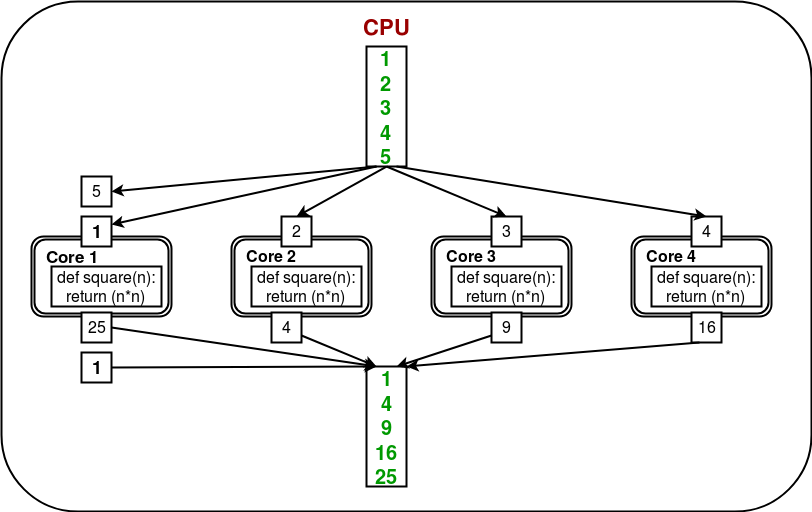

Here, the task is offloaded/distributed among the cores/processes automatically by Pool object. User doesn’t need to worry about creating processes explicitly.

In [1]:


# Python program to understand  
# the concept of pool 
import multiprocessing 
import os 
  
def square(n): 
    print("Worker process id for {0}: {1}".format(n, os.getpid())) 
    return (n*n) 
  
  
# input list 
mylist = [1,2,3,4,5] 

# creating a pool object 
p = multiprocessing.Pool() 

# map list to target function 
result = p.map(square, mylist) 

print(result) 

Worker process id for 1: 80176Worker process id for 3: 80178Worker process id for 2: 80177Worker process id for 5: 80180Worker process id for 4: 80179




[1, 4, 9, 16, 25]
